In [54]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import cv2

In [55]:
MIN_MATCH_COUNT = 10

In [56]:
def load_img(imgName1, imgName2):
    img1 = cv2.imread(imgName1)  # trainImage
    img2 = cv2.imread(imgName2)  # queryImage
    return img1, img2

In [255]:
img1, img2 = load_img('./images/input1.png', './images/input2.png')

# Transform to RGB
cv2.cvtColor(img1, cv2.COLOR_BGR2RGB, img1)
cv2.cvtColor(img2, cv2.COLOR_BGR2RGB, img2)

sift = cv2.xfeatures2d.SIFT_create()

kp1, des1 = sift.detectAndCompute(img1, None)
kp2, des2 = sift.detectAndCompute(img2,None)

FLANN_INDEX_KDTREE = 0
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks = 50)

flann = cv2.FlannBasedMatcher(index_params, search_params)

matches = flann.knnMatch(des1,des2,k=2)

# store all the good matches as per Lowe's ratio test.
good = []
for m,n in matches:
    if m.distance < 0.7*n.distance:
        good.append(m)


if len(good)>MIN_MATCH_COUNT:
    src_pts = np.float32([ kp1[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
    dst_pts = np.float32([ kp2[m.trainIdx].pt for m in good ]).reshape(-1,1,2)

    # findHomography finds the perspective transformation matrix M of src with respect to dst.
    M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)

    matchesMask = mask.ravel().tolist()
    h, w, d = img1.shape
    h2, w2, d2 = img2.shape
    pts1 = np.float32([ [0,0],[0,h],[w,h],[w,0]]).reshape(-1,1,2)
    pts2 = np.float32([ [0,0],[0,h2],[w2,h],[w2,0]]).reshape(-1,1,2)
    dst1 = cv2.perspectiveTransform(pts1,M)

#     img2_poly = cv2.polylines(img2,[np.int32(dst1)], True, 255, 3, cv2.LINE_AA)
else:
    print("Not enough matches are found - %d/%d" % (len(good),MIN_MATCH_COUNT))
    matchesMask = None

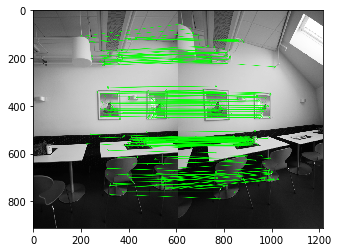

(<matplotlib.image.AxesImage at 0x1643ff5c0>, None)

In [254]:
draw_params = dict(matchColor=(0, 255, 0),  # draw matches in green color
                    singlePointColor=None,
                    matchesMask=matchesMask,  # draw only inliers
                    flags=2)

img3 = cv2.drawMatches(img1, kp1, img2, kp2, good, None, **draw_params)
plt.imshow(img3), plt.show()

x: [  0  28 750 734]
y: [   1 1273 1011  229]
x: [317 317 924 924]
y: [ 169 1080 1080  169]


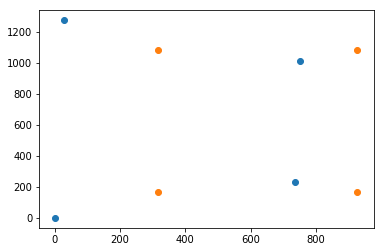

In [277]:
# Before shifting

# dst1
x = np.int32([-317.21655273, -289.98876953, 433.51797485, 417.87689209])
y = np.int32([-168.77513123, 1104.06030273, 842.82611084, 60.70239258])
x = x + (-x_min)
y = y + (-y_min)
print("x:", x)
print("y:", y)
plt.scatter(x, y)
x = np.array([0, 0, 607, 607])
y = np.array([0, 911, 911, 0])
x = x + (-x_min)
y = y + (-y_min)
print("x:", x)
print("y:", y)
plt.scatter(x, y)

In [248]:
# shifting the coordinate system such that the coordinate are greater than 0.
# Shifting = transform_array.dot(M), where M is the homography matrix of src with respect to dst.
transform_dist = [-x_min, -y_min]
transform_array = np.array([[1, 0, transform_dist[0]],
                             [0, 1, transform_dist[1]],
                             [0, 0, 1]])

In [263]:
# Resulting dimensions
result_dims = np.concatenate((dst1, pts2), axis=0)

# Getting images together
# Calculate dimensions of match points
[x_min, y_min] = np.int32(result_dims.min(axis=0).ravel() - 0.5)
[x_max, y_max] = np.int32(result_dims.max(axis=0).ravel() + 0.5)

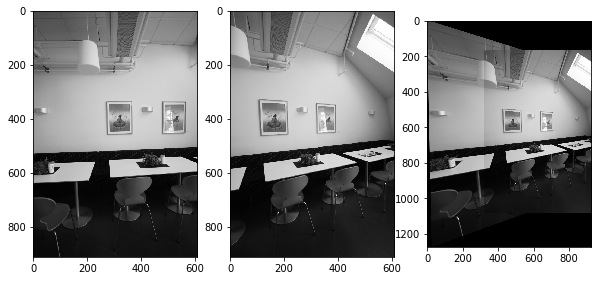

In [287]:
result = cv2.warpPerspective(img1, transform_array.dot(M), (x_max-x_min, y_max-y_min))
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(10, 10))

ax[0].imshow(img1)
ax[1].imshow(img2)

shifted_x = result.shape[1] - img2.shape[1]
result[-y_min:-y_min + img2.shape[0], -x_min:-x_min + img2.shape[1]] = img2

ax[2].imshow(result)